In [1]:
import torchvision, time, os, copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import colorcet as cc
import sys
sys.path.append(r'C:\Users\bahadur\OneDrive - KeyASIC\AI Project\AI Box Demo\saliency-master')

# From the repository
from utils import load_image, make_grayscale, make_black_white, show_mask, show_mask_on_image, cut_image_with_mask
from vanilla_gradient import VanillaGradient
from guided_backprop import GuidedBackprop
from integrated_gradients import IntegratedGradients
from grad_cam import GradCam
from xrai import XRAI

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(), # flip horizontally 50% of the time - increases train set variability
        transforms.ToTensor(), # convert it to a PyTorch tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet models expect this norm
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
data_dir = '.'

In [7]:
# Create train and validation datasets and loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

['Negative', 'Positive', 'Undetectable']
cuda:0


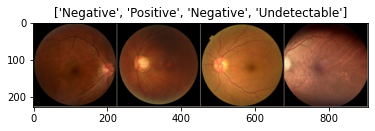

In [8]:
# Helper function for displaying images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Un-normalize the images
    inp = std * inp + mean
    # Clip just in case
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    epoch_time = [] # we'll keep track of the time needed for each epoch

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        # Add the epoch time
        t_epoch = time.time() - epoch_start
        epoch_time.append(t_epoch)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    #model.load_state_dict(best_model_wts)
    return model, epoch_time

In [22]:
# Download a pre-trained ResNet18 model and freeze its weights
model = torchvision.models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)
# Send the model to the GPU
model = model.to(device)
# Set the loss function
criterion = nn.CrossEntropyLoss()

# Observe that only the parameters of the final layer are being optimized
optimizer_conv = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model, epoch_time = train_model(model, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100)

Epoch 1/100
----------
train Loss: 1.2051 Acc: 0.4433
val Loss: 1.2502 Acc: 0.4640

Epoch 2/100
----------
train Loss: 1.1737 Acc: 0.4793
val Loss: 1.0444 Acc: 0.5530

Epoch 3/100
----------
train Loss: 1.1214 Acc: 0.5087
val Loss: 0.8811 Acc: 0.5993

Epoch 4/100
----------
train Loss: 1.1144 Acc: 0.5173
val Loss: 1.6045 Acc: 0.4903

Epoch 5/100
----------
train Loss: 1.1078 Acc: 0.5150
val Loss: 0.9056 Acc: 0.5840

Epoch 6/100
----------
train Loss: 1.0700 Acc: 0.5303
val Loss: 0.9125 Acc: 0.5853

Epoch 7/100
----------
train Loss: 0.8873 Acc: 0.5893
val Loss: 0.9175 Acc: 0.5943

Epoch 8/100
----------
train Loss: 0.8792 Acc: 0.5907
val Loss: 0.9057 Acc: 0.6003

Epoch 9/100
----------
train Loss: 0.8708 Acc: 0.5973
val Loss: 0.9011 Acc: 0.5973

Epoch 10/100
----------
train Loss: 0.8621 Acc: 0.6017
val Loss: 0.8621 Acc: 0.6147

Epoch 11/100
----------
train Loss: 0.8602 Acc: 0.6000
val Loss: 0.8737 Acc: 0.6103

Epoch 12/100
----------
train Loss: 0.8752 Acc: 0.5857
val Loss: 0.8824 Ac

In [11]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1

In [ ]:
torch.save(model.state_dict(), 'checkpoint.pth')

In [ ]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

In [ ]:
model.load_state_dict(state_dict)

In [23]:
torch.save(model, 'FUll_DR.pth')


In [13]:
model = torch.load('FUll_DR.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            #print(labels)

            outputs = model(inputs)
            print(outputs)
            _, preds = torch.max(outputs, 1)
            
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                print(j)
                print(class_names[preds[j]])
                print(preds[j])
                print(class_names)
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

tensor([[-0.3813, -1.2976,  2.1357],
        [-0.3319, -1.7413,  1.9866],
        [ 1.0691, -0.2453,  0.1041],
        [ 0.3594,  0.3971,  0.1976]], device='cuda:0')
0
Undetectable
tensor(2, device='cuda:0')
['Negative', 'Positive', 'Undetectable']


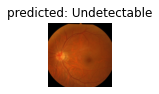

1
Undetectable
tensor(2, device='cuda:0')
['Negative', 'Positive', 'Undetectable']


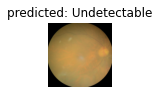

2
Negative
tensor(0, device='cuda:0')
['Negative', 'Positive', 'Undetectable']


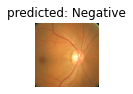

3
Positive
tensor(1, device='cuda:0')
['Negative', 'Positive', 'Undetectable']


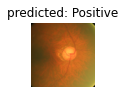

tensor([[ 0.4170, -0.3839,  0.7141],
        [-0.1354,  1.0286, -0.4210],
        [ 0.7570, -0.7967,  0.3918],
        [ 1.1179, -0.5353, -0.1155]], device='cuda:0')
0
Undetectable
tensor(2, device='cuda:0')
['Negative', 'Positive', 'Undetectable']


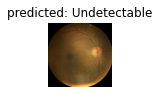

1
Positive
tensor(1, device='cuda:0')
['Negative', 'Positive', 'Undetectable']


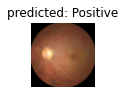

In [15]:
visualize_model(model)

tensor([[-0.6317, -0.7721,  1.5814]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor(2, device='cuda:0')


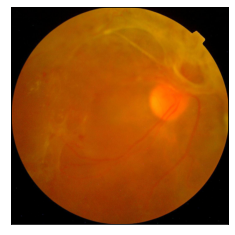

In [16]:
from PIL import Image
test_image = r'C:\Users\bahadur\OneDrive - KeyASIC\AI Project\AI Box Demo\DR\val\Abnormal\1556_Abnormal.jpg'
#test_image = r'C:\Users\bahadur\OneDrive - KeyASIC\AI Project\AI Box Demo\DR\val\Normal\41_Normal.jpg'
labels = ['Negative', 'Positive', 'Undetectable']

# First prepare the transformations: resize the image to what the model was trained on and convert it to a tensor
#data_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
data_transform = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224), transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
# Load the image
image_ = Image.open(test_image)
plt.imshow(image_), plt.xticks([]), plt.yticks([])

# Now apply the transformation, expand the batch dimension, and send the image to the GPU
image = data_transform(image_).unsqueeze(0).cuda()

out = model(image)
#preds = torch.max(outputs, 1)
print(out)
print(out.argmax())

In [77]:
#print("Predicted class is: {}".format(labels[preds[0]]))

In [17]:
print("Predicted class is: {}".format(labels[out.argmax()]))
confidence = out[0][out.argmax()]
print("* confidence: {:.4f}".format(confidence))

Predicted class is: Undetectable
* confidence: 1.5814


In [18]:
import torch.onnx
# define the directory for further converted model save
onnx_model_path = "models"
# define the name of further converted model
onnx_model_name = "resnet50.onnx"
# create directory for further converted model
os.makedirs(onnx_model_path, exist_ok=True)
# get full path to the converted model
full_model_path = os.path.join(onnx_model_path, onnx_model_name)
# generate model input
generated_input = torch.randn(1, 3, 224, 224).cuda()

# model export into ONNX format
torch.onnx.export(
    model,
    generated_input,
    full_model_path,
    verbose=True,
    input_names=["input"],
    output_names=["output"],
    opset_version=11
)

graph(%input : Float(1, 3, 224, 224),
      %conv1.weight : Float(64, 3, 7, 7),
      %bn1.weight : Float(64),
      %bn1.bias : Float(64),
      %bn1.running_mean : Float(64),
      %bn1.running_var : Float(64),
      %bn1.num_batches_tracked : Long(),
      %layer1.0.conv1.weight : Float(64, 64, 1, 1),
      %layer1.0.bn1.weight : Float(64),
      %layer1.0.bn1.bias : Float(64),
      %layer1.0.bn1.running_mean : Float(64),
      %layer1.0.bn1.running_var : Float(64),
      %layer1.0.bn1.num_batches_tracked : Long(),
      %layer1.0.conv2.weight : Float(64, 64, 3, 3),
      %layer1.0.bn2.weight : Float(64),
      %layer1.0.bn2.bias : Float(64),
      %layer1.0.bn2.running_mean : Float(64),
      %layer1.0.bn2.running_var : Float(64),
      %layer1.0.bn2.num_batches_tracked : Long(),
      %layer1.0.conv3.weight : Float(256, 64, 1, 1),
      %layer1.0.bn3.weight : Float(256),
      %layer1.0.bn3.bias : Float(256),
      %layer1.0.bn3.running_mean : Float(256),
      %layer1.0.bn3.runn

In [19]:
import cv2
# read converted .onnx model with OpenCV API
opencv_net = cv2.dnn.readNetFromONNX(full_model_path)

In [20]:
# read the image
input_img = cv2.imread(test_image, cv2.IMREAD_COLOR)
input_img = input_img.astype(np.float32)
input_img = cv2.resize(input_img, (256, 256))
# define preprocess parameters
mean = np.array([0.485, 0.456, 0.406]) * 255.0
scale = 1 / 255.0
std = [0.229, 0.224, 0.225]
# prepare input blob to fit the model input:
# 1. subtract mean
# 2. scale to set pixel values from 0 to 1
input_blob = cv2.dnn.blobFromImage(
    image=input_img,
    scalefactor=scale,
    size=(224, 224),  # img target size
    mean=mean,
    swapRB=True,  # BGR -> RGB
    crop=True  # center crop
)
# 3. divide by std
input_blob[0] /= np.asarray(std, dtype=np.float32).reshape(3, 1, 1)

In [21]:
# set OpenCV DNN input
opencv_net.setInput(input_blob)
# OpenCV DNN inference
out = opencv_net.forward()
print("OpenCV DNN prediction: \n")
print("* shape: ", out.shape)
# get the predicted class ID
imagenet_class_id = np.argmax(out)
# get confidence
confidence = out[0][imagenet_class_id]
print("* class ID: {}, label: {}".format(imagenet_class_id, labels[imagenet_class_id]))
print("* confidence: {:.4f}".format(confidence))

OpenCV DNN prediction: 

* shape:  (1, 3)
* class ID: 1, label: Positive
* confidence: 0.6761


In [30]:
confidence = out[0][0]
print(confidence)

-0.09247593


In [79]:
# Construct a saliency object and compute the saliency mask.
vanilla_gradient = VanillaGradient(model)
rgb_mask = vanilla_gradient.get_mask(image_tensor=image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


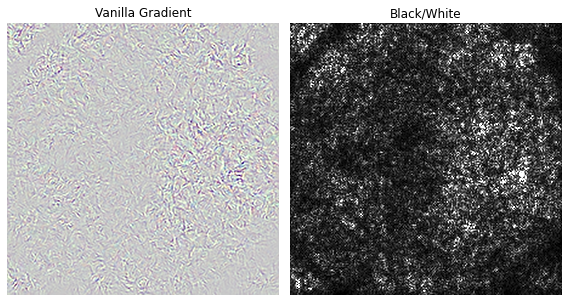

In [80]:



# Make a black and white variant of the computed saliency mask.
bw_mask = make_black_white(rgb_mask)

# Plot the RGB and black/white version alongside each other.
figure, axes = plt.subplots(1, 2, figsize=(8, 8), tight_layout=True)
show_mask(rgb_mask, title='Vanilla Gradient', axis=axes[0])
show_mask(bw_mask, title='Black/White', cmap=cc.cm.gray, axis=axes[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


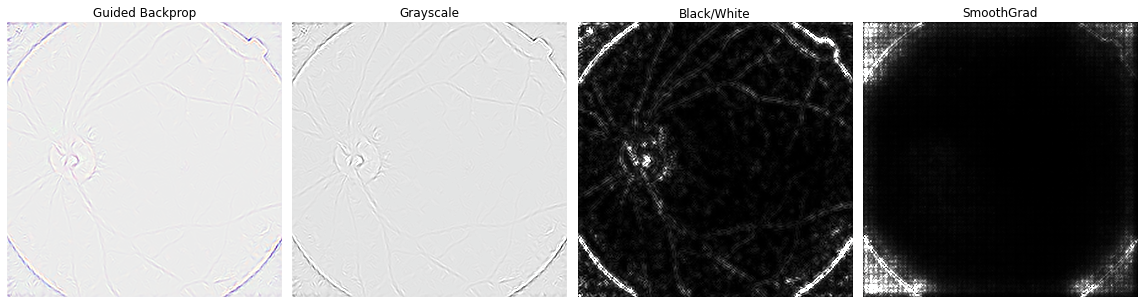

In [81]:
guided_backprop = GuidedBackprop(model)
rgb_mask = guided_backprop.get_mask(image_tensor=image)

# Vanilla Gradient, Guided Backpropagation and Integrated Gradients
# also implement a SmmothGrad variant of their saliency mask.
smooth_rgb_mask = guided_backprop.get_smoothed_mask(image_tensor=image, samples=50)

# ReLUs are modified in PyTorch using hooks
# which we need to remove after we are done.
guided_backprop.remove_hooks()

gray_mask = make_grayscale(rgb_mask)
bw_mask = make_black_white(rgb_mask)
smooth_bw_mask = make_black_white(smooth_rgb_mask)

figure, axes = plt.subplots(1, 4, figsize=(16, 16), tight_layout=True)
show_mask(rgb_mask, title='Guided Backprop', axis=axes[0])
show_mask(gray_mask, title='Grayscale', cmap=cc.cm.gray, axis=axes[1])
show_mask(bw_mask, title='Black/White', cmap=cc.cm.gray, axis=axes[2])
show_mask(smooth_bw_mask, title='SmoothGrad', cmap=cc.cm.gray, axis=axes[3])

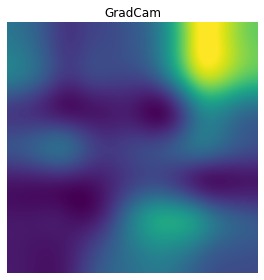

In [82]:


# Construct a saliency object and compute the saliency mask.
GradCam_ = GradCam(model)
rgb_mask = GradCam_.get_mask(image_tensor=image)

# Visualize the result
show_mask(rgb_mask, title='GradCam')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


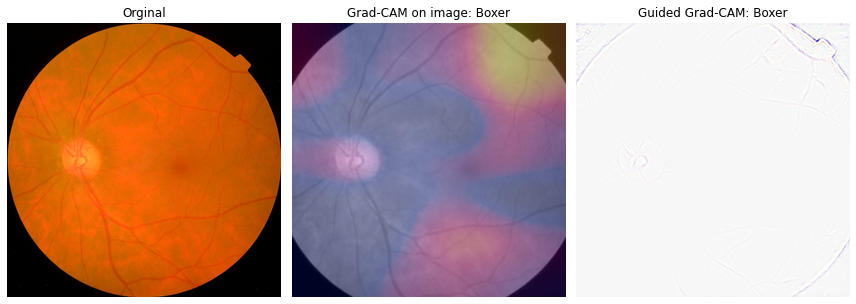

In [83]:
guided_backprop = GuidedBackprop(model)

# So far, the target class was set to the networks' prediction implicitly.
# Now, we define a desired target class explicitly.
boxer_mask = guided_backprop.get_mask(image_tensor=image)
guided_backprop.remove_hooks()

grad_cam = GradCam(model)
boxer_region = grad_cam.get_mask(image_tensor=image)
grad_cam.remove_hooks()

# 'Guided Grad-CAM' is a combination of the 'Guided Backprop' and 'Grad-CAM' method.
guided_grad_cam_boxer = guided_backprop.apply_region(boxer_mask, boxer_region)


figure, axes = plt.subplots(1, 3, figsize=(12, 12), tight_layout=True)
show_mask(image_, title='Orginal', axis=axes[0])
show_mask_on_image(test_image, mask=boxer_region, title='Grad-CAM on image: Boxer', alpha=0.3, axis=axes[1])
show_mask(guided_grad_cam_boxer, title='Guided Grad-CAM: Boxer', axis=axes[2])

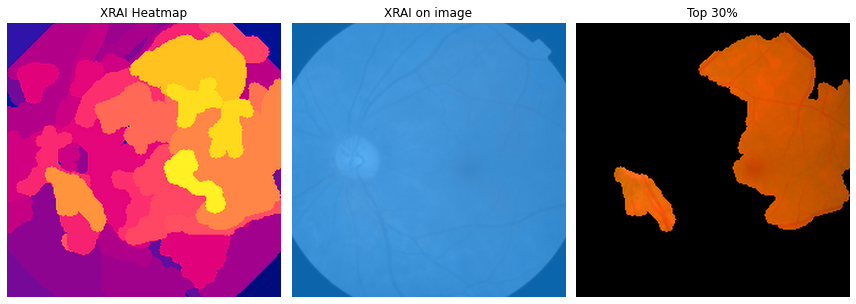

In [84]:
xrai = XRAI(model)
segments = xrai.get_mask(image_tensor=image)

figure, axes = plt.subplots(1, 3, figsize=(12, 12), tight_layout=True)
show_mask(segments, title='XRAI Heatmap', cmap=cc.cm.bmy, norm=True, axis=axes[0])
show_mask_on_image(test_image, mask=segments, title='XRAI on image', cmap=cc.cm.bky, alpha=0.7, axis=axes[1])
cut_image_with_mask(test_image, mask=segments, title='Top 30%', percentile=70, axis=axes[2])

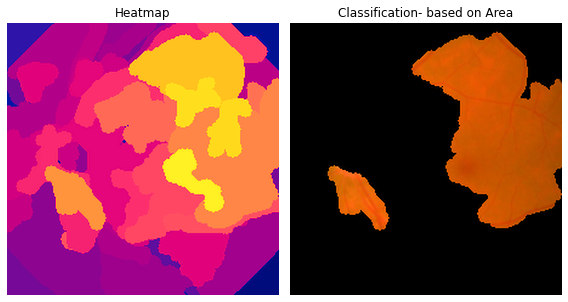

In [6]:
xrai = XRAI(model)
segments = xrai.get_mask(image_tensor=image)

figure, axes = plt.subplots(1, 2, figsize=(8, 8), tight_layout=True)
show_mask(segments, title='Heatmap', cmap=cc.cm.bmy, norm=True, axis=axes[0])
cut_image_with_mask(test_image, mask=segments, title='Classification- based on Area', percentile=70, axis=axes[1])

In [86]:
percentile=70
image_x = np.moveaxis(load_image(test_image, size=segments.shape[0], preprocess=False).numpy().squeeze(), 0, -1)
mask_x = segments > np.percentile(segments, percentile)
image_x[~mask_x] = 0
plt.imsave('region_of_focous.jpg', image_x)

In [185]:
im = Image.fromarray(mask_x)
im2 =Image.fromarray((image_x * 255).astype(np.uint8)).convert('RGB')
im.save("region_of_focous.jpeg")
im2.save("region_of_focous2.jpeg")